In [1]:
#| default_exp attention_rollout

In [13]:
#| hide
!nvidia-smi

Wed Jun  7 11:12:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 22%   24C    P8     4W / 250W |  11007MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B2:00.0 Off |                  N/A |
| 22%   

In [18]:
#| hide
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

In [19]:
#| hide
ngpu = torch.cuda.device_count()
for gpu_id in range(ngpu):
    gpu = torch.cuda.get_device_name(gpu_id)
    print(f"GPU:{gpu_id} {gpu}")

GPU:0 NVIDIA GeForce RTX 2080 Ti
GPU:1 NVIDIA GeForce RTX 2080 Ti


In [4]:
#| hide
import nbdev

In [12]:
#| export
import numpy as np
import torch
from torchvision import transforms

In [5]:
#| hide
torch.__version__

'1.13.1+cu117'

### Attention Rollout

In [10]:
#| export
def rollout(attentions, discard_ratio, head_fusion):
    """
    Gets attention matrices and returns a saliency map by propagating attention values across ViT
    transformer layers.
    For more information, consult the documentation.
    
    input :
      - attentions : list (A list of square tensor containing self-attention value for q,k of each token)
      - discard_ratio : float32 (The percentage of attentions with low values that be dropped)
      - head_fusion : str ("mean", "max", "min" defines the mode of mixing attentions from different heads)
      
    return :
      - cls_mask : ndarray (Saliency map based on the classification token of DeiT)
      - token_mask : ndarray (Saliency map based on the knowledge distillation token of DeiT)
    """
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        
        for attention in attentions: # Attention shape: (1, 3, 197, 197)
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0] # # shape: (1, 197, 197)
                # print(f"Shape before max is {attention.shape}, After: {attention.max(axis=1)}")
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Pick a proper head fusion mode"

            # Drop the lowest attentions, but
            # don't drop the class token
            # print(f"attention heads fused size : {attention_heads_fused.size(0)}")
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1) # Shape : (1, 197*197)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            # print(sum(1 if i == 0 else 0 for i in indices[0]))
            # print(indices.shape)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1) # Shape : (1, 197, 197)
            a = a[0]

            result = torch.matmul(a, result) # Shape: (1, 197, 197)
                                             # How much information do we get from the token j
                                             # in prev. layer (result) into the token i here (a)
    
    # Look at the total attention between the class token,
    # and the image patches
    cls_mask = result[0, 2:] # Shape : (196)
    token_mask = result[1, 2:] # Shape : (196)
    
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(cls_mask.size(-1)**0.5)
    cls_mask = cls_mask.reshape(width, width).numpy() # Shape : (14, 14)
    cls_mask = cls_mask / np.max(cls_mask)
    
    width = int(token_mask.size(-1)**0.5)
    token_mask = token_mask.reshape(width, width).numpy() # Shape : (14, 14)
    token_mask = token_mask / np.max(token_mask)
    return cls_mask, token_mask

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion), output

In [9]:
#| export
def grad_rollout(attentions, gradients, discard_ratio):
    """
    Gets attention matrices and returns a saliency map (based on a specific class label) by
    propagating attention values across ViT transformer layers.
    
    input :
      - attentions : list (A list of square tensor containing self-attention value for q,k of each token)
      - gradients : list (A list of class specific gradients collected through hooking with backward process of the model)
      - discard_ratio : float32 (The percentage of attentions with low values that be dropped)
      
    return :
      - mask : ndarray (Saliency map based on the classification token of DeiT)
    """
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention, grad in zip(attentions, gradients):                
            weights = grad
            attention_heads_fused = (attention*weights).mean(axis=1)
            attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask

class VITAttentionGradRollout:
    def __init__(self, model, attention_layer_name='attn_drop',
        discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        category_mask = torch.zeros(output.size()).to(device)
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()

        return grad_rollout(attentions=self.attentions,
                            gradients=self.attention_gradients,
                            discard_ratio=self.discard_ratio)

In [8]:
#| export
def vit_saliency_map(img, model, discard_ratio=0.9,
                     head_fusion='max', category_index=None, use_cuda=True):
    """
    Creates saliency map for an image using attention rollout within DeiT.
    
    input :
      - img : PIL Image (Image to be forwarded to the model)
      - model : function (DeiT model to be used)
      - discard_ratio : float32 (Optional parameter, defining the percentage of low values to be dropped)
      - head_fusion : str ("mean", "max", "min" defines the mode of mixing attentions from different heads)
      - category_index : int (Optional parameter, defining the label of the image)
      - use_cuda : boolean (Should cuda be used or not)
      
    return :
      - probs : torch.tensor (Probabilites distribution of the model)
      - cat_idx : int (Label predicted by the model)
      - masks : ndarray (Saliency generated through attention rollout process)
    """
    gpu_reference_tensor = next(model.parameters())

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    
    input_tensor = transform(img).unsqueeze(0)
    if use_cuda: input_tensor = input_tensor.cuda()

    attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
                                            discard_ratio=discard_ratio)
    masks, output = attention_rollout(input_tensor)

    probs = torch.nn.functional.softmax(output, dim=1)
    cat_idx = torch.argmax(probs).item()
    
    return probs, cat_idx, masks

In [12]:
#| hide
import sys
import os
from PIL import Image, ImageDraw
import imageio
import torch.nn as nn
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import timm
from timm.models.vision_transformer import trunc_normal_

Using cache found in /home/hashimi/.cache/torch/hub/facebookresearch_deit_main


243


/tmp/ipykernel_1990701/3175821694.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(output)


Text(0.5, 1.0, 'Class: bull_mastiff (26.64%)')

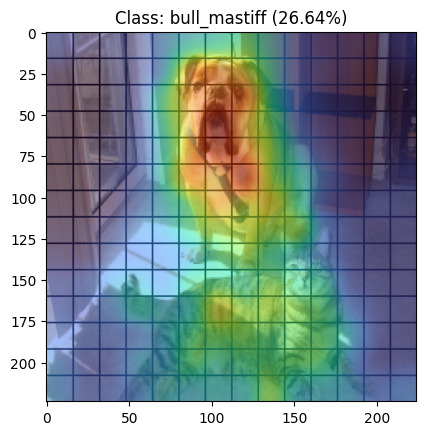

In [13]:
#| hide
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

model = torch.hub.load('facebookresearch/deit:main',  'deit_tiny_patch16_224', pretrained=True).to(device)
model.eval()

gpu_reference_tensor = next(model.parameters())

classes = open("classes.txt").read().splitlines()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

img_path = './examples/input.png'
img = Image.open(img_path)
img = img.resize((224, 224))
patch_size = 16

input_tensor = transform(img).unsqueeze(0)
steps = int(224/patch_size)

if use_cuda:
    input_tensor = input_tensor.cuda()

category_index = None
head_fusion = 'max'
discard_ratio = 0.9
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
        discard_ratio=discard_ratio)
mask, output = attention_rollout(input_tensor)

probs = torch.nn.functional.softmax(output)
cat_idx = torch.argmax(probs).item()
print(cat_idx)

np_img = np.array(img)
for x in range(steps-1):
    pos = (x+1)*patch_size
    np_img[:, pos:pos+1, :] = 0
    np_img[pos:pos+1, :, :] = 0

fig, ax = plt.subplots()
heatmap = Image.fromarray(mask)
heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
ax.imshow(np_img)
heatmap = (heatmap / np.max(heatmap)) * 255.0
ax.imshow(heatmap, cmap='turbo', # seismic, hot, Reds
          alpha=0.5)
ax.set_title(f"Class: {classes[cat_idx]} ({probs[0, cat_idx].item()*100:.2f}%)")

In [1]:
#| hide
from nbdev.export import nb_export
nb_export('attention_rollout.ipynb', '../../commons/api/method')